#  TOMATO PLANT DISEASE IMAGE IDENTIFICATION AND CLASSIFICATION USING DEEP LEARNING

## problem statement:  

Has to classify the given tomato image as one among the 9 categories of diseases identified    or as a healthy plant

###  1. Importing packages 
###  2.setting all the constants for the model  
###  3.Downloading dataset and converting to numpy array 
    - 3.1. Visualizing  the images from dataset
    - 3.2. split data into train,test and validation  
###  4.Building the CNN model  
    - 4.1. accuracy for the  model 
    - 4.2. predict
###  5.Save the model 

### Importing all the packages

In [1]:
import pandas as pd 
import numpy as np 
import warnings 
import os 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
 
warnings.filterwarnings('ignore')

### Set all the constants

In [2]:
batch_size=32
image_size=256
channels=3
epochs=25


### Downloading the dataset and converting the images into array

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\jithu\Downloads\PlantVillage",
                                                            seed=123)

dataset



Found 16011 files belonging to 10 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names=dataset.class_names 

class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 4 6 0 7 9 6 6 7 4 7 1 1 0 7 0 7 0 9 0 5 7 2 1 4 7 9 9 1 2 5]


### Visualizing some of the images from  dataset

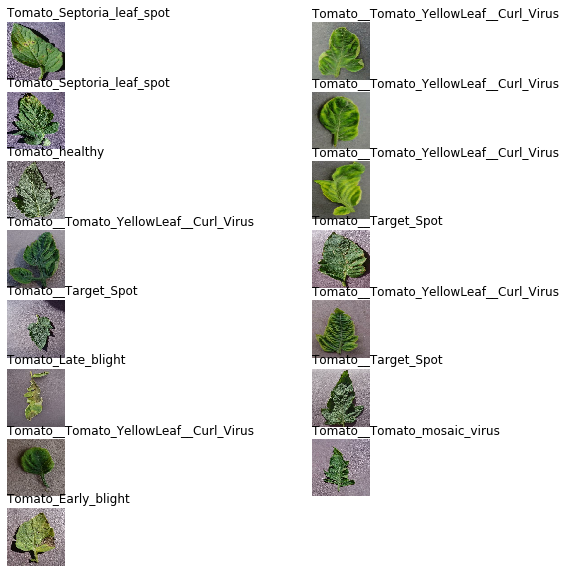

In [6]:
plt.figure(figsize=(10,10))

for image_batch ,labels_batch in dataset.take(1):
    for i in range(15):
        ax=plt.subplot(8,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]],loc='left')
        plt.axis('off') 
        

### Dataset should be splitted into 3 subsets.

1.Training: Dataset to be used while training
2.validation: Dataset to be tested against while training
3.Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

501

In [8]:
def get_dataset_partitions(ds,train_split=0.7,test_split=0.15,val_split=0.15,shuffle=True,shuffle_size=10000): 
    assert (train_split + test_split + val_split) == 1 
    ds_size=len(ds) 
    
    if shuffle:
        
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(len(ds)*train_split) 
    
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds   

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [10]:
len(train_ds),len(val_ds),len(test_ds)

(350, 75, 76)

### Cache, Shuffle, and Prefetch the Dataset

In [11]:
train_ds=train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE) 

test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds=val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

Creating a Layer for Resizing and Normalization

In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),  #reshaping any image to (256,256)
    layers.experimental.preprocessing.Rescaling(1./255),                #converting all values b/w 0 and 1 
])

Applying Data Augmentation to Train Dataset

In [13]:
data_aug=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [15]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    #layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Dropout(0.2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'), 
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  
    #layers.Dropout(0.2), 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  
   
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

Compiling the Model

In [17]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics='accuracy')

In [18]:
history=model.fit(train_ds,batch_size=batch_size,validation_data=val_ds,verbose=1,epochs=25)

Epoch 1/25
350/350 [==============================] - 1042s 3s/step - loss: 1.8319 - accuracy: 0.3384 - val_loss: 1.6626 - val_accuracy: 0.4225
Epoch 2/25
350/350 [==============================] - 875s 2s/step - loss: 1.4402 - accuracy: 0.4783 - val_loss: 1.3113 - val_accuracy: 0.5225
Epoch 3/25
350/350 [==============================] - 996s 3s/step - loss: 1.0870 - accuracy: 0.6112 - val_loss: 0.9617 - val_accuracy: 0.6633
Epoch 4/25
350/350 [==============================] - 1329s 4s/step - loss: 0.7476 - accuracy: 0.7344 - val_loss: 1.1331 - val_accuracy: 0.6604
Epoch 5/25
350/350 [==============================] - 1552s 4s/step - loss: 0.6071 - accuracy: 0.7880 - val_loss: 0.9162 - val_accuracy: 0.7063
Epoch 6/25
350/350 [==============================] - 1637s 5s/step - loss: 0.4908 - accuracy: 0.8282 - val_loss: 1.4278 - val_accuracy: 0.6908
Epoch 7/25
350/350 [==============================] - 1460s 4s/step - loss: 0.4333 - accuracy: 0.8476 - val_loss: 0.5213 - val_accuracy: 0

In [19]:
scores=model.evaluate(test_ds)

76/76 [==============================] - 130s 599ms/step - loss: 0.1915 - accuracy: 0.9346


In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 350}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
len(history.history['loss'])

25

In [24]:
history.history['loss'][:2] # show loss for first 5 epochs


[1.83188796043396, 1.4401909112930298]

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

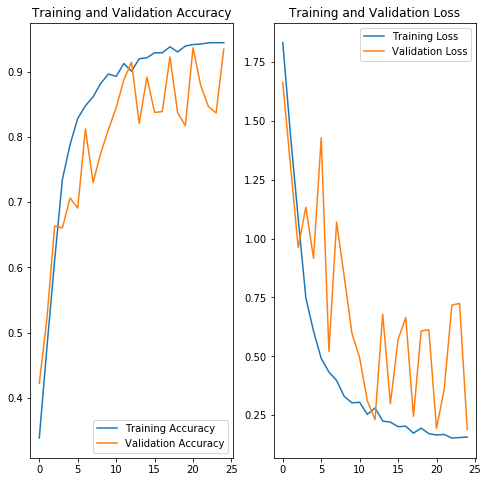

In [26]:
EPOCHS =25
plt.figure(figsize=(8, 8))
plt.subplot(1, 2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Bacterial_spot
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_Bacterial_spot


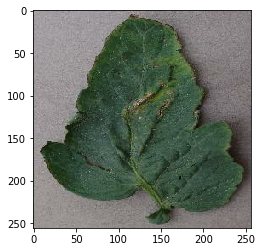

In [27]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Now running inference on few sample images

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #converting to batches 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


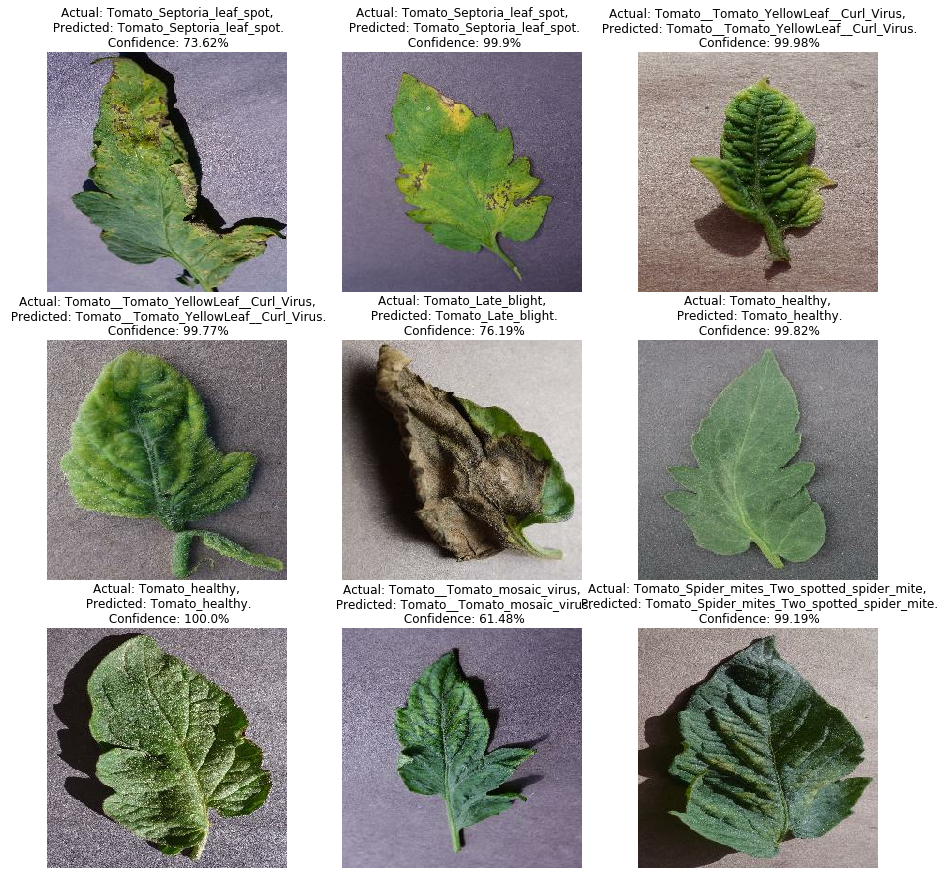

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### saving the model

In [30]:
#model.save("./tomato.h5")